In [322]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [323]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# load data
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [324]:
df = train.copy()
df.head()
df = df.groupby('date')[['sales', 'onpromotion']].sum()
df = df.to_period('D')
df.head()

,sales,onpromotion
date,,
2013-01-01,2511.618999,0
2013-01-02,496092.417944,0
2013-01-03,361461.231124,0
2013-01-04,354459.677093,0
2013-01-05,477350.121229,0


In [325]:
# shape
df.shape

(1684, 2)

<Axes: xlabel='onpromotion', ylabel='sales'>

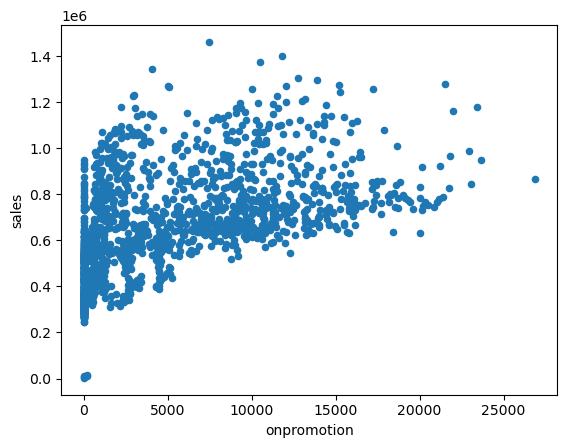

In [326]:
# plotting onpromotion agt sales to check for any correlation
df.plot(x='onpromotion', y='sales', kind='scatter')

<Axes: xlabel='date'>

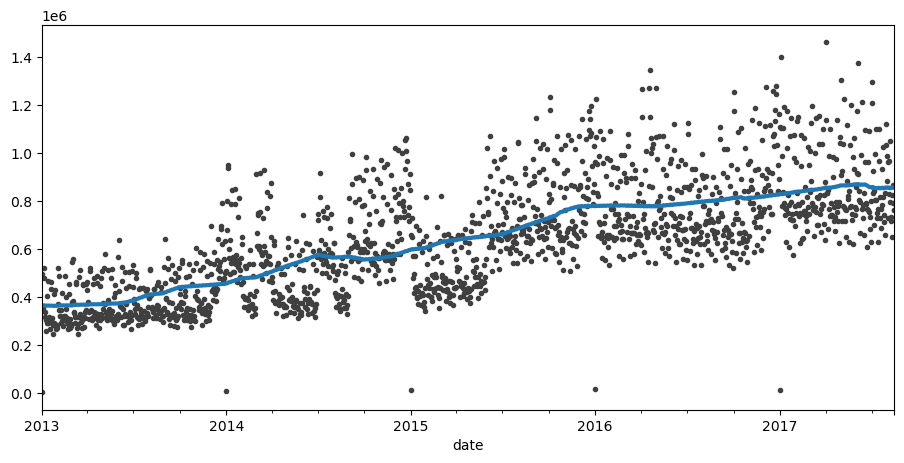

In [327]:
fig, ax = plt.subplots(figsize=(11,5))
# moving average plot
mvp = df['sales'].rolling(window=365, center=True, min_periods=185).mean()

ax = df['sales'].plot(style='.', color='0.25')
mvp.plot(ax=ax, linewidth=3)

In [328]:
# sales lag
df['sales_lag1'] = df.sales.shift(1)
df['sales_lag2'] = df.sales.shift(2)

df = df.fillna(0.0)
df.head()

,sales,onpromotion,sales_lag1,sales_lag2
date,,,,
2013-01-01,2511.618999,0,0.000000,0.000000
2013-01-02,496092.417944,0,2511.618999,0.000000
2013-01-03,361461.231124,0,496092.417944,2511.618999
2013-01-04,354459.677093,0,361461.231124,496092.417944
2013-01-05,477350.121229,0,354459.677093,361461.231124


<Axes: xlabel='sales_lag1', ylabel='sales'>

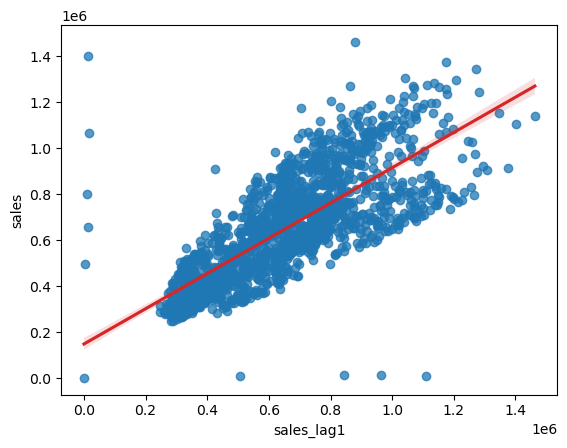

In [329]:
# ax = df.plot(x='sales_lag', y='sales', kind='scatter')
sns.regplot(data=df, x='sales_lag1', y='sales', scatter_kws=dict(alpha=0.75), line_kws=dict(color='C3'))


## Modelling

### 1. Time-step feature

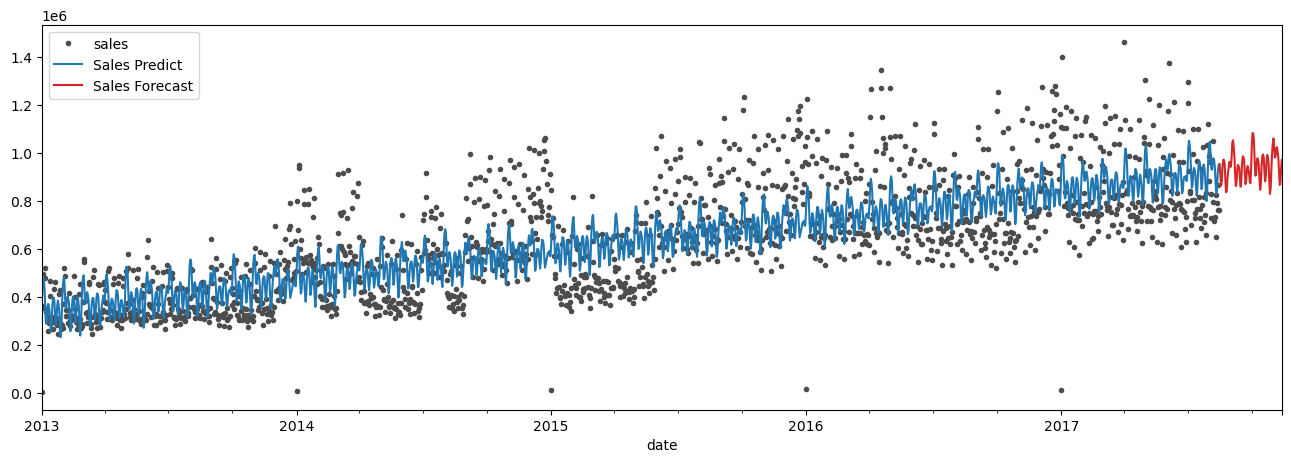

In [330]:
fig, ax = plt.subplots(figsize=(16,5))

# determistic process
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(index=df.index, constant=True, drop=True, 
                          seasonal=True, order=1, additional_terms=[fourier])

X = dp.in_sample()

X.head()
y = df.loc[ :, 'sales']

from sklearn.linear_model import LinearRegression

lrg = LinearRegression(fit_intercept=False).fit(X, y)
y_pred = pd.Series(lrg.predict(X), index=X.index)

X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(lrg.predict(X_fore), index=X_fore.index)

ax = y.plot(style='.', color='0.3')
ax = y_pred.plot(ax=ax,label='Sales Predict')
ax = y_fore.plot(ax=ax, color='C3', label='Sales Forecast')
ax.legend()

### Lag Features

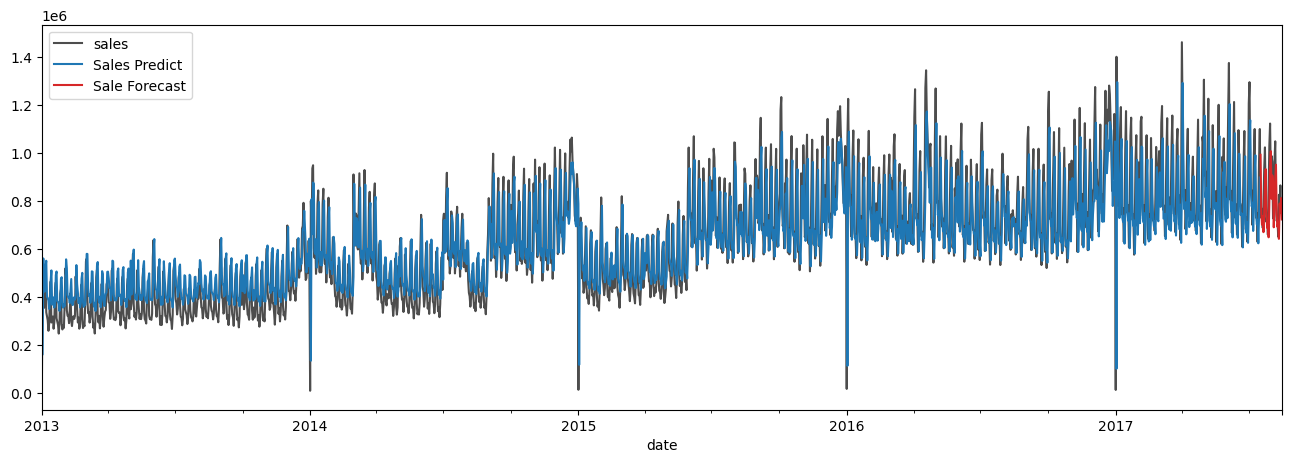

In [331]:
fig, ax = plt.subplots(figsize=(16,5))

from sklearn.model_selection import train_test_split

X = df[['sales_lag1',  'sales_lag2']]
y = df['sales']

X_train, X_fore, y_train, y_fore = train_test_split(X, y, test_size=30, shuffle=False)

lrg = LinearRegression().fit(X_train, y_train)
y_pred = pd.Series(lrg.predict(X_train), index=X_train.index)
y_fore = pd.Series(lrg.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.30')
ax = y_pred.plot(ax=ax, label='Sales Predict')
ax = y_fore.plot(ax=ax,  color='C3', label='Sale Forecast')
ax.legend()

## Predicting test data

In [332]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [333]:
test.groupby('date')

TypeError: unsupported Type RangeIndex